This code is intended as a demo of my understanding of sequential data and not for market use. Crypto market is highly volatile and not suitable for trading.


**The problem** ; given price and volume going back a certain number of lookback timesteps, and sampled every step, can we predict the price movement in delay_period number of periods in the future?

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing 

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
lookback = 30  # how long of a preceeding sequence to collect in minutes
delay_period = 2  # how far into the future are we trying to predict in minutes?
RATIO_TO_PREDICT = "LTC-USD"
    
main_df = pd.DataFrame() 

ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]  # the 4 ratios we want to consider
for ratio in ratios:  
    print(ratio)
    dataset = f'{ratio}.csv'  
    df = pd.read_csv(dataset, names=['time',  'close', 'volume'], usecols=[0,4,5], index_col='time')  # read in specific file

    # rename volume and close to include the ticker so we can still which close/volume is which:
    df.rename(columns={"close": f"{ratio}_close", "volume": f"{ratio}_volume"}, inplace=True)
    df = df[[f"{ratio}_close", f"{ratio}_volume"]] 

    if len(main_df)==0:  
        main_df = df  
    else:  
        main_df = main_df.join(df) # join on index; time.


main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
main_df.dropna(inplace=True)
   
main_df['future'] = main_df[f'{RATIO_TO_PREDICT}_close'].shift(-delay_period) #shift cells up 2 periods

In [ ]:
def classify(current, future):
    if float(future) > float(current):
        return 1 #indicates a buy if future price is greater than current.
    else:
        return 0 # indicates a sell
    
main_df['target'] = list(map(classify, main_df[f'{RATIO_TO_PREDICT}_close'], main_df['future']))
main_df = main_df.drop("future", 1) 

# normalizing
for col in main_df.columns:  
    if col != "target":  
        main_df[col] = main_df[col]/(main_df[col].iloc[0])
print(main_df.head()) 

In [ ]:
print(main_df['target'].value_counts()) # 1 and 0 values are disproportionate in count.

In [ ]:
drop_number = (main_df.target.value_counts()).iloc[0]-(main_df.target.value_counts()).iloc[1]
zero_class = []
for i, row in enumerate(main_df.target):
    if row == 0:
        zero_class.append(i) #append indexes with zero class
        
zero_class_dropped = np.random.choice(zero_class, drop_number)
main_df = main_df.reset_index().drop(zero_class_dropped).set_index('time')
print(main_df.target.value_counts())

In [ ]:
# Because the samples in the dataset are highly redundant it would be computationally expensive
# to pass every sample through the neural net. Instead, the generator generates samples with a step of 2.
# Its also a great way to seperate the training data from validation and test sets.
# The generator takes the input array of data and yields
# batches of data of size 200 along with a target, zero or one, for each sequence. 
def generator(data, lookback, min_index, max_index, batch_size=200, step=2):
    if max_index is None:
        max_index = len(data)  - 1
    i = min_index + lookback

    while True:
        if i + batch_size >= max_index:
            i = min_index + lookback
        rows = np.arange(i, min(i + batch_size, max_index))
        i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]-1)) #(samples, lookback steps, features)  
        targets = np.zeros((len(rows),)) 

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data.iloc[indices, 0:8]                           
            targets[j] = data.iloc[rows[j]][8]        
        yield samples, targets
        
train_gen = generator(main_df, lookback=lookback ,min_index=0, max_index=58030, step=2)
val_gen = generator(main_df, lookback=lookback ,min_index=58001, max_index=70031, step=2)
test_gen = generator(main_df, lookback=lookback  ,min_index=70002, max_index=81032, step=2)

In [8]:
# recommended to run on gpu, change lstm to cuDNNLSTM and remove the activation argument.
model = Sequential([
    LSTM(128, input_shape=(15, 8), activation='tanh', recurrent_dropout=0.2, return_sequences=True),
    LSTM(128, activation='tanh', recurrent_dropout=0.2, return_sequences=True),
    LSTM(128, activation='tanh', recurrent_dropout=0.2),


    Dense(64, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')    
    ])


# Compile and run model
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='binary_crossentropy',optimizer=opt ,metrics=['accuracy'])
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_acc', save_best_only=True)
history = model.fit_generator(train_gen, steps_per_epoch=290, epochs=20,validation_data=val_gen, validation_steps=60,
                              callbacks= [checkpoint], verbose=2)      


Epoch 1/20
 - 99s - loss: 0.6914 - acc: 0.5274 - val_loss: 0.6952 - val_acc: 0.5134
Epoch 2/20
 - 93s - loss: 0.6914 - acc: 0.5237 - val_loss: 0.6917 - val_acc: 0.5218
Epoch 3/20
 - 95s - loss: 0.6907 - acc: 0.5290 - val_loss: 0.6915 - val_acc: 0.5262
Epoch 4/20
 - 92s - loss: 0.6906 - acc: 0.5280 - val_loss: 0.6912 - val_acc: 0.5248
Epoch 5/20
 - 96s - loss: 0.6904 - acc: 0.5290 - val_loss: 0.6912 - val_acc: 0.5248
Epoch 6/20
 - 97s - loss: 0.6902 - acc: 0.5306 - val_loss: 0.6912 - val_acc: 0.5245
Epoch 7/20
 - 95s - loss: 0.6900 - acc: 0.5317 - val_loss: 0.6912 - val_acc: 0.5245
Epoch 8/20
 - 97s - loss: 0.6900 - acc: 0.5316 - val_loss: 0.6912 - val_acc: 0.5266
Epoch 9/20
 - 92s - loss: 0.6900 - acc: 0.5312 - val_loss: 0.6911 - val_acc: 0.5281
Epoch 10/20
 - 93s - loss: 0.6898 - acc: 0.5329 - val_loss: 0.6911 - val_acc: 0.5293
Epoch 11/20
 - 88s - loss: 0.6898 - acc: 0.5315 - val_loss: 0.6911 - val_acc: 0.5300
Epoch 12/20
 - 88s - loss: 0.6898 - acc: 0.5323 - val_loss: 0.6912 - val_a

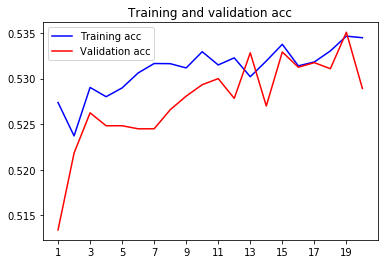

In [11]:
# visualizing the epochs
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xticks(range(1, len(acc) + 1, 2))
plt.legend()
plt.show()

In [12]:
# Out of sample test set evaluation
model = Sequential([
    LSTM(128, input_shape=(15, 8), activation='tanh', recurrent_dropout=0.2, return_sequences=True),
    LSTM(128, activation='tanh', recurrent_dropout=0.2, return_sequences=True),
    LSTM(128, activation='tanh', recurrent_dropout=0.2),

    Dense(64, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')    
    ])

model.load_weights('weights.hdf5')

model.compile(loss='binary_crossentropy',optimizer=opt ,metrics=['accuracy'])

test_eval = model.evaluate_generator(test_gen, steps=55)
print(f'Out of sample test set accuracy is {test_eval[1]*100:.2f}')

Out of sample test set accuracy is 53.19
